# Simulacion de canciones en Spotify!

### 1-  Objetivos: 
- A lo largo del proyecto se pretende encontrar si existe una distribución de probabilidad en las principales canciones (en base a popularidad) de nuestra base de datos. 

- En caso de encontrar que una distribución de probabilidad en particular se ajusta bastante bien a una variable en particular, se asumiría que esa variable es: global, que todas las canciones lo consideran del mismo modo o, indiferente, de tal forma que no afecta esa variable a la probabilidad de exito de la canción seleccionada. 

### 2- Definición del problema: 
- El problema surge desde el momento en el que se paga a un artista por la cantidad de visitas que tienen en conjunto sus canciones. Por lo tanto lo que se busca en todo momento es maximizar la probabilidad de conseguir una canción con mas 'views'. Con las variables que nos proveen directamente desde la API de spotify (mismas que se expresarán posteriormente) analizaremos la distribución de probabilidad que mejor se ajuste y además utilizaremos un a distribución ajustada por kernels. La mejor de las distribuciones se comparará con su semejante en las canciones no-populares. En caso de haber un 'shift' o una tendencia muy notoria en comparación con la distribución de su contraparte, se asumirá que la variable analizada es uno de los principales factores que determinan la popularidad de una canción. 

A lo largo de este proyecto se pretende analizar las canciones más populares y por lo tanto las variables de las cuales depende mayormente. A final del proyecto se espera tener las condiciones que maximicen la probabilidad de tener una canción popular.

algunas de las variables a analizar son: 

- 'acousticness', 
- 'artists', 
- 'danceability', 
- 'duration_ms', 
- 'energy',
- 'explicit', 
- 'id', 
- 'instrumentalness', 
- 'key', 
- 'liveness', 
- 'loudness',    
- 'mode', 
- 'name', 
- 'popularity', 
- 'release_date', 
- 'speechiness', 
- 'tempo',
- 'valence', 
- 'year'
      

más información acerca de estas variables y su significado desde la documentación oficial de spotify: https://developer.spotify.com/documentation/web-api/reference/#endpoint-get-track

- acousticness:

A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. 	

- danceability:

Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. 	

- duration_ms:

The duration of the track in milliseconds. 	

- energy:

Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. 	

- id:

The Spotify ID for the track. 	

- instrumentalness:

Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. 	

- key:

The key the track is in. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. 	

- liveness:

Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live. 	

- loudness:

The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db. 	

- mode:

Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0. 	

- speechiness:

Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. 	

- tempo:

The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. 	

- time_signature:

An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). 	

- valence:

A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import concurrent.futures
import scipy.stats as st

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

warnings.simplefilter("ignore")

Nuestra base de datos se conforma de la siguiente manera:

In [20]:
data = pd.read_csv('archive/data.csv')
data = data[data['popularity']>0]
data = data[data['duration_ms']<600000]
data = data[data['instrumentalness'] > 0.0]
data.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920


In [21]:
len(data)

96230

#### Popularity

Tomaremos únicamente aquellas que sean escuchadas 'regularmente'. Se eliminarán aquellas que tengan un valor de pupularidad 0. 

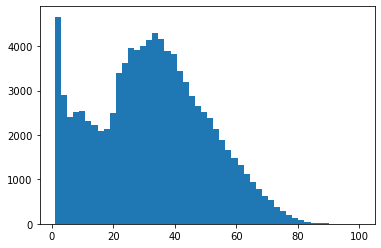

In [22]:
plt.hist(data['popularity'], bins = 50);

#### Danceability

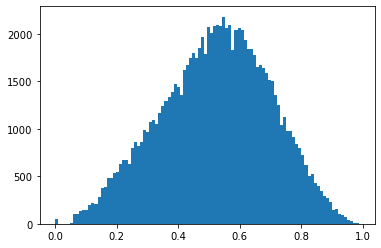

In [23]:
plt.hist(data['danceability'],bins = 100);

#### Valence

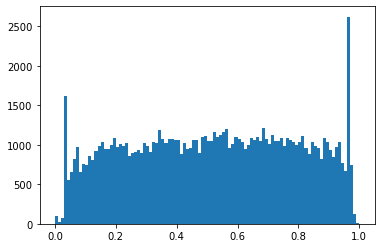

In [24]:
plt.hist(data['valence'] ,bins = 100);

#### Energy

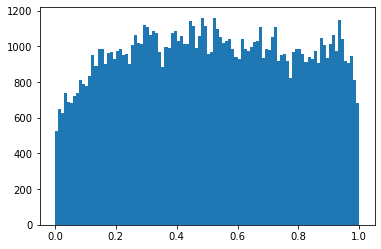

In [25]:
plt.hist(data['energy'] ,bins = 100);

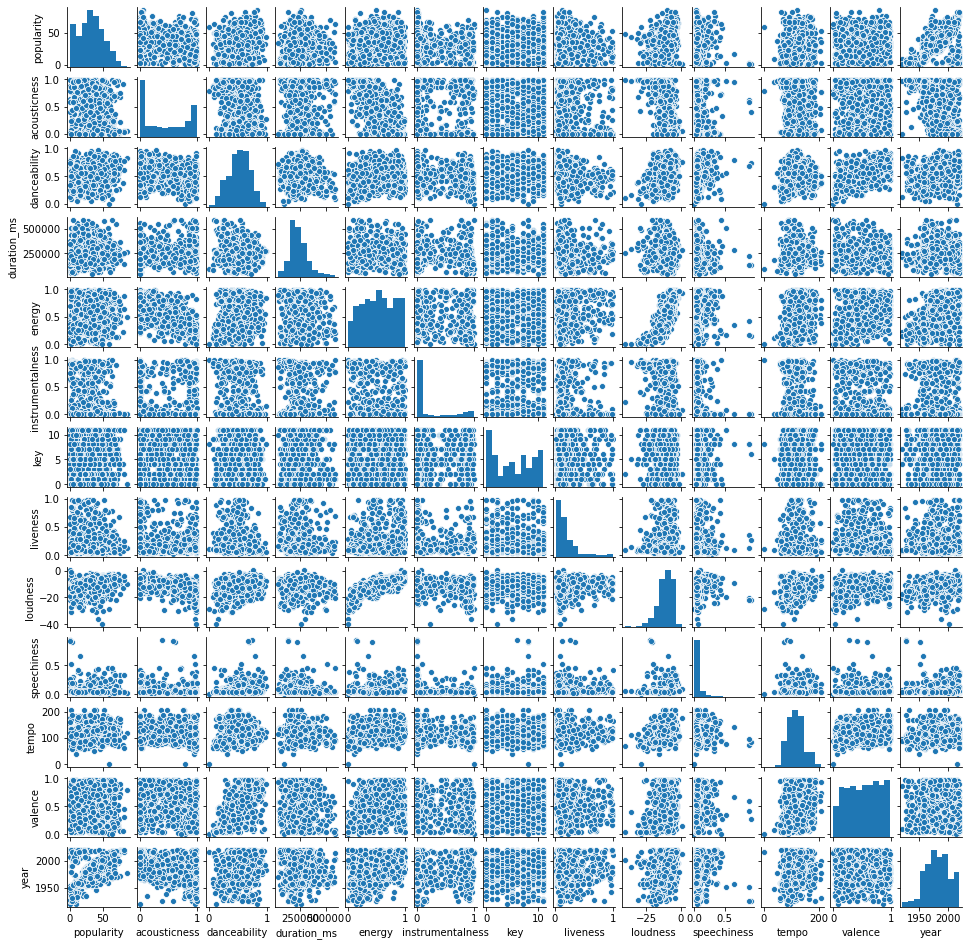

In [26]:
sns_plot = sns.pairplot(data.sample(1000), height=1, vars=['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 
       'speechiness', 'tempo', 'valence', 'year'])
plt.show()

A Simple vista parece no existir correlación entre la popularidad de las canciones y las otras variables (excepto año en la que se publicó la canción)

Se procederá a hacer estimaciones de distribuciones de probabilidad a los mejores 10% de las canciones. Lo esperado sería obtener una distribución desplazada o concentrada en alguna de las variables. 

Se tomarán únicamente las variables 'Popularity', 'Danceability', 'Acousticness', 'Valence', 'Energy', 'Tempo' y 'Loudness' 

In [27]:
# Solo como demostración se imprimen los primeros 10 lugares del ranking
data.sort_values(['popularity'], ascending=False).head(10)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
20062,0.721,['Olivia Rodrigo'],0.585,242014,0.436,1,7lPN2DXiMsVn7XUKtOW1CS,0.000013,10,0.105,-8.761,1,drivers license,100,2021-01-08,0.0601,143.874,0.132,2021
19886,0.401,"['Bad Bunny', 'Jhay Cortez']",0.731,205090,0.573,1,47EiUVwUp4C9fGccaPuUCS,0.000052,4,0.113,-10.059,0,DÁKITI,95,2020-10-30,0.0544,109.928,0.145,2020
19976,0.212,['KAROL G'],0.863,178947,0.666,1,7vrJn5hDSXRmdXoR30KgF1,0.000493,1,0.103,-4.158,0,BICHOTA,95,2020-10-23,0.1520,163.908,0.838,2020
19876,0.218,['Billie Eilish'],0.889,174321,0.340,0,54bFM56PmE4YLRnqpW6Tha,0.130000,11,0.055,-7.773,0,Therefore I Am,94,2020-11-12,0.0697,94.009,0.716,2020
19878,0.650,['Pop Smoke'],0.709,160000,0.548,1,1tkg4EHVoqnhR6iFEXb60y,0.000002,10,0.133,-8.493,1,What You Know Bout Love,93,2020-07-03,0.3530,83.995,0.543,2020
20068,0.181,['Justin Bieber'],0.686,190779,0.538,0,31qCy5ZaophVA81wtlwLc4,0.000003,2,0.113,-8.026,1,Anyone,92,2021-01-01,0.0345,115.884,0.584,2021
39252,0.414,['Tiësto'],0.798,164000,0.620,0,6f3Slt0GbA2bPZlz0aIFXN,0.019200,8,0.112,-7.079,0,The Business,92,2020-09-16,0.2320,120.031,0.235,2020
76406,0.362,['Boza'],0.725,186133,0.756,0,3VvA1wSxukMLsvXoXtlwWx,0.000685,4,0.103,-5.013,1,Hecha Pa' Mi,92,2020-07-31,0.0572,100.070,0.828,2020
20018,0.401,"['Bad Bunny', 'Jhay Cortez']",0.731,205090,0.573,1,4MzXwWMhyBbmu6hOcLVD49,0.000052,4,0.113,-10.059,0,DÁKITI,91,2020-11-27,0.0544,109.928,0.145,2020
19864,0.499,['SZA'],0.436,279204,0.655,1,3YJJjQPAbDT7mGpX3WtQ9A,0.000008,1,0.688,-8.370,0,Good Days,91,2020-12-25,0.0583,121.002,0.412,2020


In [28]:
r_data = data.sort_values(['popularity'], ascending=False).head(int(len(data)*0.1))
n_data = data.sort_values(['popularity'], ascending=True).head(int(len(data)*0.9))

In [29]:
n_bins = int(np.sqrt(len(r_data)))
n_bins

98

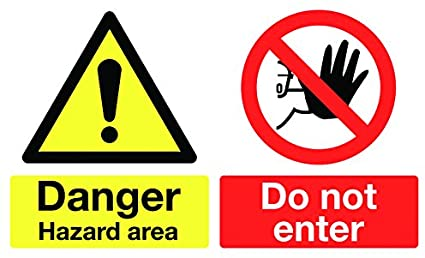

## El código a continuación puede demorar demasiado. Continúe bajo su propio riesgo.

In [33]:
def kde(x, bandwidth = 1, **kwargs):
    """Kernel Density Estimation with Scikit-learn when optimal bandwidth is known"""
    
    rng = max(x) - min(x)
    x_grid = np.linspace(min(x)-rng*0.05,max(x)+rng*0.05, 500)
    

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return x_grid, np.exp(log_pdf)

In [31]:
def kde_w_best_bandwidth(x, **kwargs):
    """Kernel Density Estimation with Scikit-learn when optimal bandwidth is unknown"""
    def bandwidth_search(x):
        grid = GridSearchCV(KernelDensity(),
                        {'bandwidth': np.linspace(0.01, abs(rng*0.1), 30)},
                        cv=20) # 20-fold cross-validation
        grid.fit(x[:, None])
        return (grid.best_params_) 
    
    
    rng = max(x) - min(x)
    x_grid = np.linspace(min(x)-rng*0.05,max(x)+rng*0.05, 500)
    
    opt_bandwidth = bandwidth_search(r_data['popularity'])['bandwidth']
    print("best bandwidth: {}".format(opt_bandwidth))
    
    kde_skl = KernelDensity(bandwidth=opt_bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    

    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return x_grid, np.exp(log_pdf)


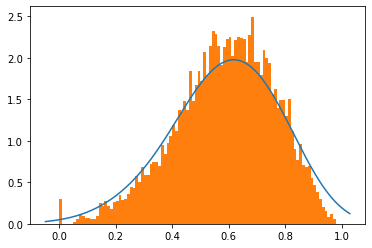

In [34]:
# x,pdf = kde_w_best_bandwidth(r_data['danceability']) # best bandwidth: 0.098
x,pdf = kde(r_data['danceability'], bandwidth = 0.098)
plt.plot(x,pdf);
plt.hist(r_data['danceability'] ,bins = n_bins, density=True);

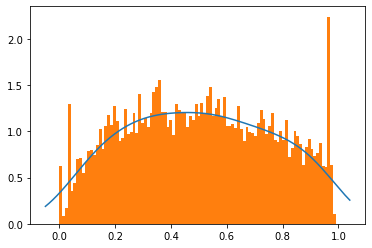

In [35]:
# x,pdf = kde_w_best_bandwidth(r_data['valence'])# best bandwidth: 0.09910000000000001
x,pdf = kde(r_data['valence'], bandwidth = 0.0991)
plt.plot(x,pdf);
plt.hist(r_data['valence'] ,bins = n_bins, density=True);

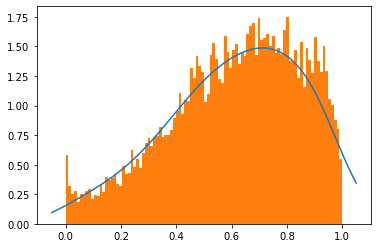

In [36]:
# x,pdf = kde_w_best_bandwidth(r_data['energy']) #best bandwidth: 0.09999797
x,pdf = kde(r_data['energy'], bandwidth = 0.09999797)
plt.plot(x,pdf);
plt.hist(r_data['energy'] ,bins = n_bins, density=True);

## Ajuste de distribuciones

In [37]:
import time

In [38]:
def best_fit_distribution(data, bins=1000, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.beta,st.chi,st.chi2,
        st.expon,st.f,st.fisk,
        st.gamma,st.gengamma,st.genhalflogistic,
        st.halfgennorm,
        st.johnsonsu,st.laplace,
        st.loggamma,st.lognorm,st.lomax,
        st.norm,st.pareto,st.powerlaw,st.powerlognorm,
        st.semicircular,st.triang,st.truncexpon,
        st.uniform]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:
        t = time.time()
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass
        print(f'Ended {distribution} in {time.time()-t}')

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

In [52]:
%timeit
with concurrent.futures.ThreadPoolExecutor() as executor:
    future_popularity = executor.submit(best_fit_distribution, r_data['popularity'], 1000)
    future_danceability = executor.submit(best_fit_distribution, r_data['danceability'], 1000)
    future_valence = executor.submit(best_fit_distribution, r_data['valence'], 1000)
    future_energy = executor.submit(best_fit_distribution, r_data['energy'], 1000)
        
    future_popularity_np = executor.submit(best_fit_distribution, n_data['popularity'], 1000)
    future_danceability_np = executor.submit(best_fit_distribution, n_data['danceability'], 1000)
    future_valence_np = executor.submit(best_fit_distribution, n_data['valence'], 1000)
    future_energy_np = executor.submit(best_fit_distribution, n_data['energy'], 1000)
    
    res_popularity = future_popularity.result()
    res_danceability = future_danceability.result()
    res_valence = future_valence.result()
    res_energy = future_energy.result()
    
    res_popularity_np = future_popularity_np.result()
    res_danceability_np = future_danceability_np.result()
    res_valence_np = future_valence_np.result()
    res_energy_np = future_energy_np.result()
    

Ended <scipy.stats._continuous_distns.alpha_gen object at 0x00000196D0F3F880> in 0.6091065406799316
Ended <scipy.stats._continuous_distns.anglit_gen object at 0x00000196D0F3FC70> in 0.19011378288269043
Ended <scipy.stats._continuous_distns.alpha_gen object at 0x00000196D0F3F880> in 0.996941328048706
Ended <scipy.stats._continuous_distns.alpha_gen object at 0x00000196D0F3F880> in 1.0113871097564697
Ended <scipy.stats._continuous_distns.alpha_gen object at 0x00000196D0F3F880> in 1.025454044342041
Ended <scipy.stats._continuous_distns.alpha_gen object at 0x00000196D0F3F880> in 1.0437066555023193
Ended <scipy.stats._continuous_distns.anglit_gen object at 0x00000196D0F3FC70> in 0.07999277114868164
Ended <scipy.stats._continuous_distns.anglit_gen object at 0x00000196D0F3FC70> in 0.06968379020690918
Ended <scipy.stats._continuous_distns.anglit_gen object at 0x00000196D0F3FC70> in 0.11016249656677246
Ended <scipy.stats._continuous_distns.anglit_gen object at 0x00000196D0F3FC70> in 0.1596453189

Ended <scipy.stats._continuous_distns.loggamma_gen object at 0x00000196D0FA8700> in 0.1796424388885498
Ended <scipy.stats._continuous_distns.loggamma_gen object at 0x00000196D0FA8700> in 0.26006436347961426
Ended <scipy.stats._continuous_distns.lognorm_gen object at 0x00000196D0FA8E20> in 1.4495716094970703
Ended <scipy.stats._continuous_distns.johnsonsu_gen object at 0x00000196D0F92430> in 2.110017776489258
Ended <scipy.stats._continuous_distns.laplace_gen object at 0x00000196D0F92700> in 0.0
Ended <scipy.stats._continuous_distns.fisk_gen object at 0x00000196D0F49F70> in 4.739914894104004
Ended <scipy.stats._continuous_distns.lognorm_gen object at 0x00000196D0FA8E20> in 1.4805736541748047
Ended <scipy.stats._continuous_distns.lognorm_gen object at 0x00000196D0FA8E20> in 1.4898674488067627
Ended <scipy.stats._continuous_distns.lomax_gen object at 0x00000196D0FBC190> in 0.7469096183776855
Ended <scipy.stats._continuous_distns.norm_gen object at 0x00000196D0F3F580> in 0.0
Ended <scipy.st

Ended <scipy.stats._continuous_distns.lomax_gen object at 0x00000196D0FBC190> in 0.9402899742126465
Ended <scipy.stats._continuous_distns.norm_gen object at 0x00000196D0F3F580> in 0.0
Ended <scipy.stats._continuous_distns.lomax_gen object at 0x00000196D0FBC190> in 0.9297125339508057
Ended <scipy.stats._continuous_distns.norm_gen object at 0x00000196D0F3F580> in 0.0
Ended <scipy.stats._continuous_distns.lognorm_gen object at 0x00000196D0FA8E20> in 1.4498391151428223
Ended <scipy.stats._continuous_distns.pareto_gen object at 0x00000196D0FBCD00> in 2.299983501434326
Ended <scipy.stats._continuous_distns.lomax_gen object at 0x00000196D0FBC190> in 0.8402340412139893
Ended <scipy.stats._continuous_distns.norm_gen object at 0x00000196D0F3F580> in 0.0
Ended <scipy.stats._continuous_distns.powerlaw_gen object at 0x00000196D0FCD3A0> in 0.660114049911499
Ended <scipy.stats._continuous_distns.pareto_gen object at 0x00000196D0FBCD00> in 2.3501193523406982
Ended <scipy.stats._continuous_distns.paret

### Danceability

Most popular songs:

('beta', (9.234066654904806, 3.984171627925045, -0.4202125529000418, 1.4427696468665954))


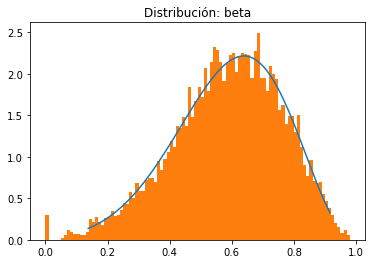

In [53]:
print(res_danceability)
pdf_danceability = make_pdf(getattr(st, res_danceability[0]), res_danceability[1])
pdf_danceability.plot()
plt.hist(r_data['danceability'] ,bins = n_bins, density=True);
plt.title(f'Distribución: {res_danceability[0]}')
plt.show()

The not so popular songs:

('gengamma', (0.5344855837660545, 5.058216040982159, -0.008103008379994434, 0.6960203967538032))


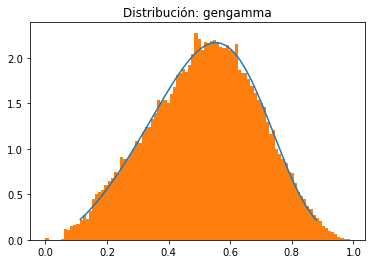

In [54]:
print(res_danceability_np)
pdf_danceability_np = make_pdf(getattr(st, res_danceability_np[0]), res_danceability_np[1])
pdf_danceability_np.plot()
plt.hist(n_data['danceability'] ,bins = n_bins, density=True);
plt.title(f'Distribución: {res_danceability_np[0]}')
plt.show()

Both of them together

<AxesSubplot:>

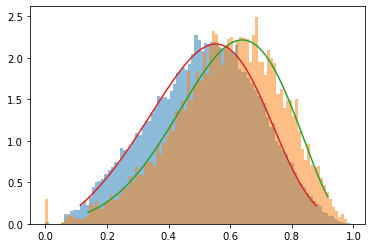

In [58]:
plt.hist(n_data['danceability'] ,bins = n_bins, density=True, alpha = 0.5);
plt.hist(r_data['danceability'] ,bins = n_bins, density=True, alpha = 0.5);
pdf_danceability.plot()
pdf_danceability_np.plot()

### Valence

Most popular songs:

('beta', (1.334509864989943, 1.272098912243636, -0.003786284948220806, 0.9948742573010495))


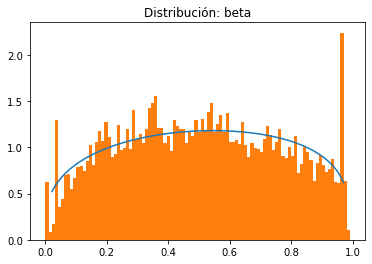

In [60]:
print(res_valence)
pdf_valence = make_pdf(getattr(st, res_valence[0]), res_valence[1])
pdf_valence.plot()
plt.hist(r_data['valence'], bins = n_bins, density=True);
plt.title(f'Distribución: {res_valence[0]}')
plt.show()

Not so popular songs:

('gengamma', (0.011886095475034327, 98.47692596214088, -0.0001961443117333904, 0.9799351581303579))


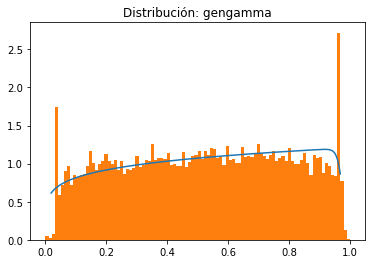

In [59]:
print(res_valence_np)
pdf_valence_np = make_pdf(getattr(st, res_valence_np[0]), res_valence_np[1])
pdf_valence_np.plot()
plt.hist(n_data['valence'], bins = n_bins, density=True);
plt.title(f'Distribución: {res_valence_np[0]}')
plt.show()

Both of them together

<AxesSubplot:>

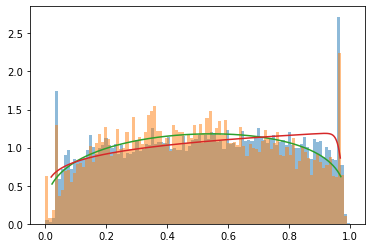

In [61]:
plt.hist(n_data['valence'] ,bins = n_bins, density=True, alpha = 0.5);
plt.hist(r_data['valence'] ,bins = n_bins, density=True, alpha = 0.5);
pdf_valence.plot()
pdf_valence_np.plot()

### Energy

Most popular songs:

('beta', (2.457937565088802, 1.3685753062696353, -0.0859607604224357, 1.0864727064654205))


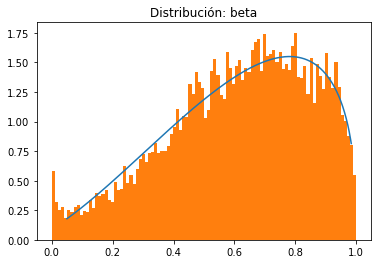

In [63]:
print(res_energy)
pdf_energy = make_pdf(getattr(st, res_energy[0]), res_energy[1])
pdf_energy.plot()
plt.hist(r_data['energy'] ,bins = n_bins, density=True);
plt.title(f'Distribución: {res_energy[0]}')
plt.show()

Not so popular songs:

('beta', (1.1136861955281887, 1.089043707633381, 1.691674059396075e-05, 1.0000100872247373))


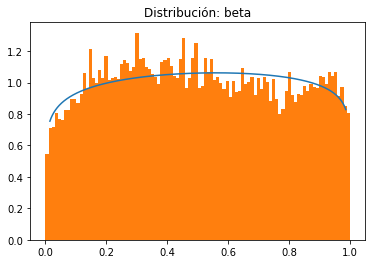

In [62]:
print(res_energy_np)
pdf_energy_np = make_pdf(getattr(st, res_energy_np[0]), res_energy_np[1])
pdf_energy_np.plot()
plt.hist(n_data['energy'] ,bins = n_bins, density=True);
plt.title(f'Distribución: {res_energy_np[0]}')
plt.show()

Both of them together

<AxesSubplot:>

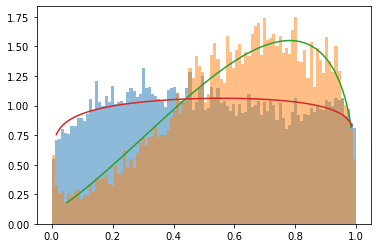

In [65]:
plt.hist(n_data['energy'] ,bins = n_bins, density=True, alpha = 0.5);
plt.hist(r_data['energy'] ,bins = n_bins, density=True, alpha = 0.5);
pdf_energy.plot()
pdf_energy_np.plot()

## Aceptacion Rechazo

## Comprobación de Distribuciones

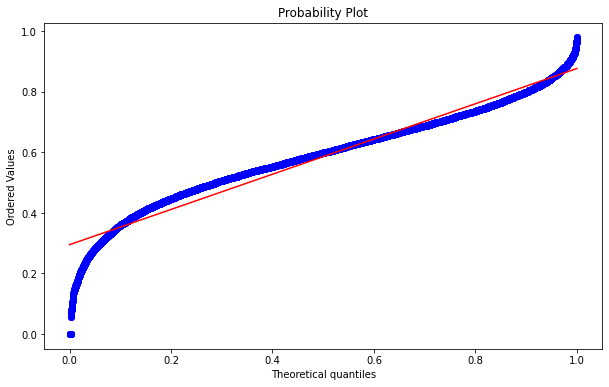

In [67]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

prob_plt = st.probplot(r_data['danceability'], 
                       dist=res_danceability[0], 
                       sparams=getattr(st, res_danceability[0]).fit(x)[:-2], 
                       fit=True, plot=ax)
plt.show()

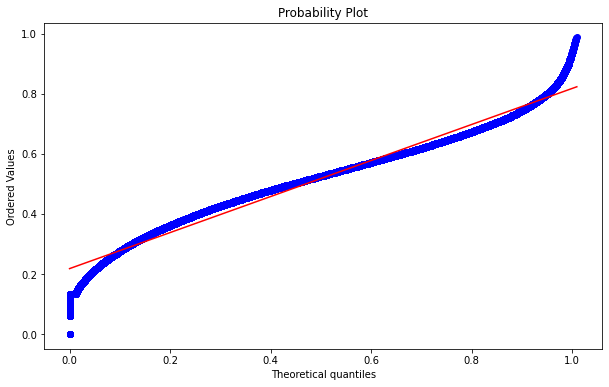

In [68]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

prob_plt = st.probplot(n_data['danceability'], 
                       dist=res_danceability_np[0], 
                       sparams=getattr(st, res_danceability_np[0]).fit(x)[:-2], 
                       fit=True, plot=ax)
plt.show()

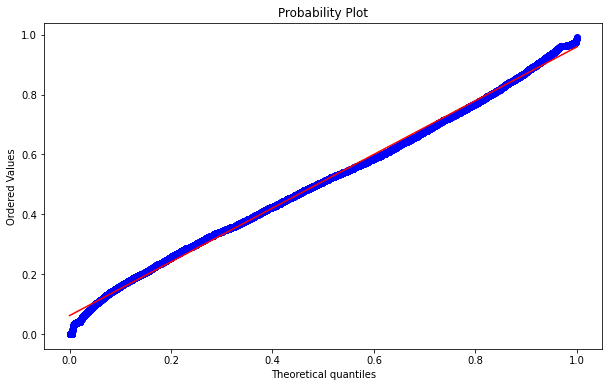

In [132]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))

prob_plt = st.probplot(r_data['valence'], 
                       dist=res_valence[0], 
                       sparams=getattr(st, res_valence[0]).fit(x)[:-2], 
                       fit=True, plot=ax)
plt.show()

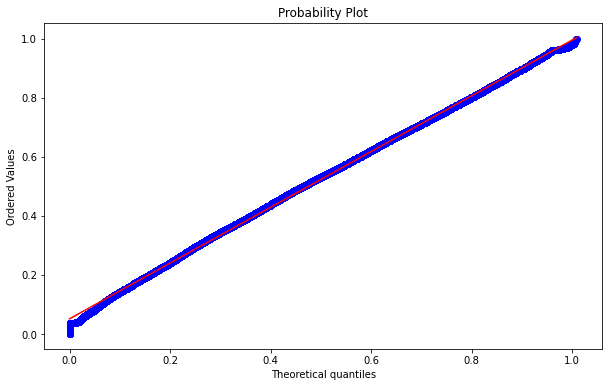

In [69]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))

prob_plt = st.probplot(n_data['valence'], 
                       dist=res_valence_np[0], 
                       sparams=getattr(st, res_valence_np[0]).fit(x)[:-2], 
                       fit=True, plot=ax)
plt.show()

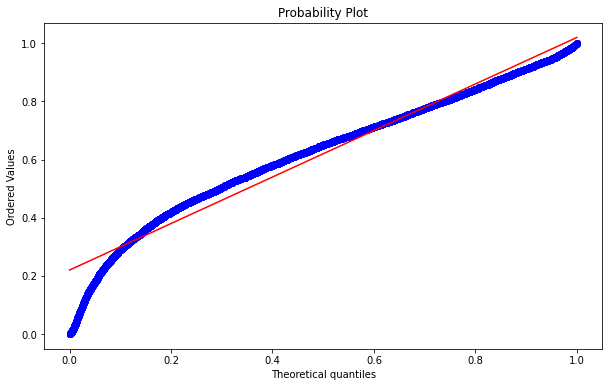

In [131]:

fig, ax = plt.subplots(1,1, figsize=(10,6))

prob_plt = st.probplot(r_data['energy'], 
                       dist=res_energy[0], 
                       sparams=getattr(st, res_energy[0]).fit(x)[:-2], 
                       fit=True, plot=ax)
plt.show()

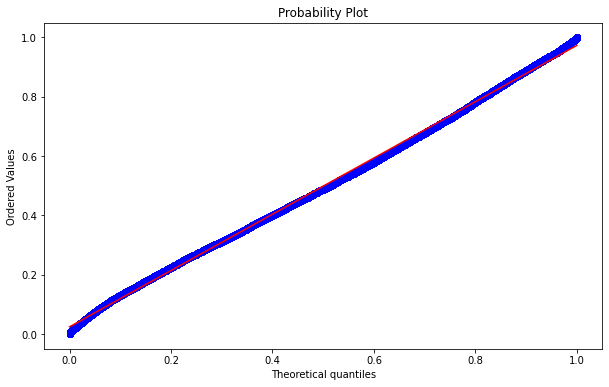

In [70]:

fig, ax = plt.subplots(1,1, figsize=(10,6))

prob_plt = st.probplot(n_data['energy'], 
                       dist=res_energy_np[0], 
                       sparams=getattr(st, res_energy_np[0]).fit(x)[:-2], 
                       fit=True, plot=ax)
plt.show()

### Muestreo estratificado 


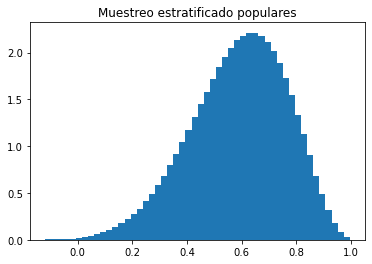

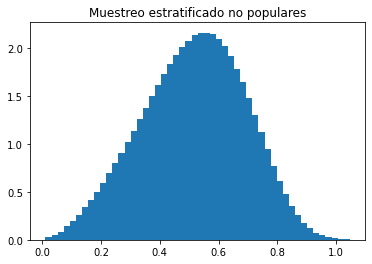

In [90]:
# Danceability!

# Método muestreo estratificado (B estratos)
B = 10000
U2 = np.random.rand(B)
i = np.arange(0, B)
m_estratificado = st.beta.ppf((U2 + i)/B, 9.234066654904792, 3.984171627924603, -0.4202125529000409, 1.4427696468665492 )

plt.hist(m_estratificado,50,density=True)
plt.title('Muestreo estratificado populares')
plt.show()

# Método muestreo estratificado (B estratos)
B = 10000
U2 = np.random.rand(B)
i = np.arange(0, B)
m_estratificado_np = st.gengamma.ppf((U2 + i)/B, 0.5344855837660545, 5.058216040982159, -0.008103008379994434, 0.6960203967538032)

plt.hist(m_estratificado_np,50,density=True)
plt.title('Muestreo estratificado no populares')
plt.show()

In [91]:
st.chisquare(m_estratificado, m_estratificado_np, ddof=3)

Power_divergenceResult(statistic=120.05767028731356, pvalue=1.0)

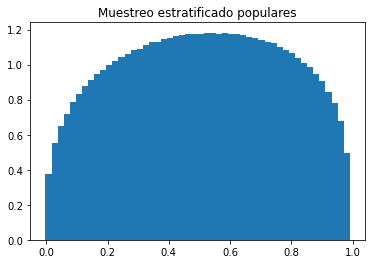

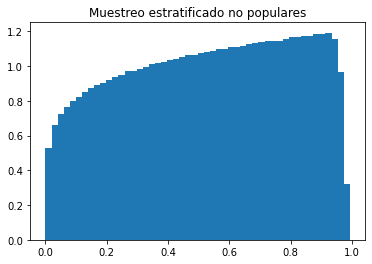

In [92]:
# Valence

# Método muestreo estratificado (B estratos)
B = 10000
U2 = np.random.rand(B)
i = np.arange(0, B)
m_estratificado = st.beta.ppf((U2 + i)/B, 1.3345098649897857, 1.2720989122435586, -0.003786284948220806, 0.9948742573010495)

plt.hist(m_estratificado,50,density=True)
plt.title('Muestreo estratificado populares')
plt.show()

# Valence

# Método muestreo estratificado (B estratos)
B = 10000
U2 = np.random.rand(B)
i = np.arange(0, B)
m_estratificado_np = st.gengamma.ppf((U2 + i)/B, 0.011886095475034327, 98.47692596214088, -0.0001961443117333904, 0.9799351581303579)

plt.hist(m_estratificado_np,50,density=True)
plt.title('Muestreo estratificado no populares')
plt.show()

In [93]:
st.chisquare(m_estratificado, m_estratificado_np, ddof=3)

Power_divergenceResult(statistic=10.281389961997359, pvalue=1.0)

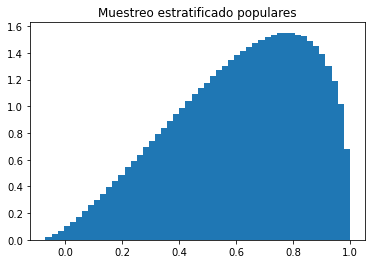

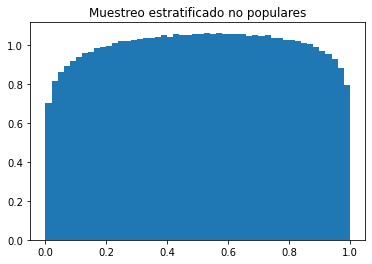

In [94]:
# Energy

# Método muestreo estratificado (B estratos)
B = 10000
U2 = np.random.rand(B)
i = np.arange(0, B)
m_estratificado = st.beta.ppf((U2 + i)/B, 2.457937565091309, 1.3685753062697519, -0.0859607604224357, 1.086472706465651)

plt.hist(m_estratificado,50,density=True)
plt.title('Muestreo estratificado populares')
plt.show()



B = 10000
U2 = np.random.rand(B)
i = np.arange(0, B)
m_estratificado_np = st.beta.ppf((U2 + i)/B, 1.1136861955281887, 1.089043707633381, 1.691674059396075e-05, 1.0000100872247373)

plt.hist(m_estratificado_np,50,density=True)
plt.title('Muestreo estratificado no populares')
plt.show()

In [95]:
st.chisquare(m_estratificado, m_estratificado_np, ddof=3)

Power_divergenceResult(statistic=704.9234783147836, pvalue=1.0)

## Conclusiones